# Uncapacitated Multiple Allocation HLP Problem.
### Autor: Saúl Sosa Díaz
---
## El problema.
El Problema de Ubicación de Concentradores de Múltiple Asignación Sin Capacidad (UMAHLP), un tema vital en la investigación de operativa, involucra la determinación estratégica de la ubicación óptima de concentradores (hubs) y la asignación eficiente de nodos a estos puntos. En el UMAHLP, el objetivo principal es seleccionar concentradores de una lista de ubicaciones potenciales, asignando cada nodo no concentrador a uno o más de estos hubs. El fin es minimizar el costo total, que generalmente abarca el transporte entre nodos y concentradores, y en ocasiones, los costos operativos de los hubs. A diferencia de otros desafíos en la ubicación de concentradores, el UMAHLP se distingue por no tener restricciones de capacidad, permitiendo que cada concentrador maneje cualquier volumen de tráfico o demanda. Además, la característica de múltiple asignación permite que un nodo se asocie con más de un concentrador, incrementando la flexibilidad.

Consideremos un conjunto de nodos $ V$ y un número $ p$ de hubs por abrir en un grafo completo $ G=(V,A)$, donde $ |V|=n$. La cantidad de producto transportado del nodo $ i \in V$ al nodo $ j \in V$ se define como $ d_{ij}$. El costo unitario de transporte a lo largo del arco $ (i,j) \in A$ se representa por $ c_{ij}$.

Para modelar el costo de transporte, se introducen los siguientes factores, dependiendo del tipo de arco $ (i,j)$:

* Un factor de descuento $ \alpha$, donde $ 0 \le \alpha \le 1$, se aplica cuando el arco conecta dos hubs.
* Un factor de recolección $ \chi$, con $ \chi > \alpha$, se utiliza cuando el arco va de un nodo origen a un hub.

Tras establecer claramente el problema, estamos listos para abordar la construcción del modelo matemático.

**Variables**
 
 * $z_{ij}$ es 1 si el nodo $i\in V$ es asignado al hub $j\in V$ y 0 en otro caso. Si los índices coinciden de tal manera que $z_{jj}$, la variable toma el valor de 1 si se abre un hub en $j\in V$, y 0 en otro caso.
 * $X_{ijkm}$ es una variable continua que representa la fracción de la demanda $w_{ij}$ que se envía de $i$ a $j$ a través de los hubs $k$ y $m$. 
 * $g_{ijkm} = d_{ij}(\chi c_{ik} + \alpha c_{km} + \delta c_{mj} ) $, que representa el coste total del producto enviado desde $i$ a $j$ que pasa por las oficinas $k$ y $m$.

**Función Objetivo**
$$
\begin{align}
    \min & \sum_{k\in N} f_k z_{kk} + \sum_{i,j,k,m\in N} g_{ijkm} x_{ijkm}
\end{align}
$$

**Sujeto a**:
$$
\begin{array}{cc}
&\sum_{k\in N} z_{ik} = 1 & i\in N\\
& \sum_{k \in N} z_{kk} <= p \\
&z_{ik} \leq z_{kk} & i,k\in N\\
&z_{ik} \in \{0,1\} & i,k\in N\\
&\sum_{m\in N} x_{ijkm} = z_{ik} & i,j,k\in N\\
&\sum_{k\in N} x_{ijkm} = z_{jm} & i,j,m\in N\\
&x_{ijkm} \geq 0 & i,j,k,m\in N
\end{array}
$$


## Resolución del problema.
Importamos los paquetes necesarios.

In [1]:
import Pkg
Pkg.add("JuMP")
Pkg.add("GLPK")
Pkg.add("Plots")


using JuMP, GLPK, Random, Plots, Random, LinearAlgebra



   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


### Introducimos los datos.

In [44]:
n = 10
N = 1:n

Random.seed!(5656)
d = rand(0:100,n,n)
c = rand(1:100,n,n)
f = rand(1:100,n)
# Assigning coordinates based on c
coordinates_nodes = Dict()
for i in N
    coordinates_nodes[i] = (c[i, 1], c[i, 2])
    d[i, i] = 0
    c[i, i] = 0
end




p = 3
α = 0.2
χ = 2
δ = 3

g_ijkm = Array{Float64}(undef, n, n, n, n)
for i in N, j in N, k in N, m in N
    g_ijkm[i,j,k,m] = d[i,j] * (χ * c[i,k] + α * c[k,m] + δ * c[m,j])
end


Preparamos la representación de los datos.

In [3]:
function DrawInstance(client_location, factory_location, supply, demand)
    Xc = client_location[1]
    Yc = client_location[2]
    Xf = factory_location[1]
    Yf = factory_location[2]
    p = scatter( # Plot the clients
        Xc,
        Yc;
        label = nothing,
        markershape = :circle,
        markercolor = :green,
        markersize = 2 .* (2 .+ demand)
    )
    scatter!( # Plot the factories
        Xf,
        Yf;
        label = nothing,
        markershape = :star5,
        markercolor = :yellow,
        markersize = supply,
        markerstrokewidth = 2,
    )


    display(p)
end

function draw_solution(z, N, node_coordinates, scale_size = 1.0)
    # Extract X and Y coordinates of the nodes
    Xn = [node_coordinates[n][1] for n in N]
    Yn = [node_coordinates[n][2] for n in N]

    p = scatter( # Plot the nodes
        Xn,
        Yn;
        label = nothing,
        markershape = :circle,
        markercolor = :green,
        markersize = [scale_size for _ in N]
    )

    # Identify hubs and draw them
    hubs = []
    for k in N
        if value(z[k, k]) > 0.5
            push!(hubs, k)
            scatter!(
                [node_coordinates[k][1]],
                [node_coordinates[k][2]];
                label = "Hub $k",
                markershape = :star5,
                markercolor = :yellow,
                markersize = 2 * scale_size,
                markerstrokewidth = 2,
            )
        end
    end

    # Plot the connections between hubs
    for i in hubs
        for j in hubs
            if i != j
                plot!(
                    [node_coordinates[i][1], node_coordinates[j][1]],
                    [node_coordinates[i][2], node_coordinates[j][2]];
                    color = :red,
                    label = nothing,
                    linestyle = :dash,
                )
            end
        end
    end

    # Plot the connections between nodes and hubs
    for i in N
        for k in hubs
            if i != k && value(z[i, k]) > 0.5
                plot!(
                    [node_coordinates[i][1], node_coordinates[k][1]],
                    [node_coordinates[i][2], node_coordinates[k][2]];
                    color = :blue,
                    label = nothing,
                )
            end
        end
    end

    display(p)
end


draw_solution (generic function with 2 methods)

### Construir el modelo.

In [49]:
function solveCRPC()
    EPS = 0.00001
    model = Model(GLPK.Optimizer)
    set_silent(model)
    
    # Variables
    @variable(model, z[i in N, k in N], Bin)
    @variable(model, x[i in N, j in N, k in N, m in N] >= 0)

    # Objective
    @objective(model, Min, sum(f[k] * z[k,k] for k in N) + sum(g_ijkm[i,j,k,m] * x[i,j,k,m] for i in N, j in N, k in N, m in N))
    
    # Constraints
    # Hub Node Assignment Restrictions
    @constraint(model, [i=1:n], sum(z[i,k] for k=1:n) >= 1 )
    @constraint(model, [i=1:n,k=1:n], z[i,k] <= z[k,k] )

    @constraint(model, sum(z[k, k] for k in N) <= p) # Number of hubs
    
    # Flow Conservation Restrictions
    for i in N, j in N, k in N
        @constraint(model, sum(x[i,j,k,:] ) == z[i,k]) 
    end
    for i in N, j in N, m in N
        @constraint(model, sum(x[i,j,:,m]) == z[j,m]) 
    end

    # Resolve model
    optimize!(model)

    # Show solutions
    if termination_status(model) == OPTIMAL
        println("Solution:")
        println("   Objective value: ", objective_value(model))
        for i in N
            if value(z[i, i]) > EPS
                println("   Hub ", i, " open ")
            end
        end
        for i in N, j in N, k in N, m in N
            if value(x[i,j,k,m]) > EPS
                println("   Node ", i, " send to the node ", j, " thought the hubs ", k, " and ", m)
            end
        end
        draw_solution(value.(z), N, coordinates_nodes,10)

    else
        println("infeasible")
        return -1
    end
    
end


solveCRPC (generic function with 1 method)

Resolvemos y mostramos el resultado.

Solution:
   Objective value: 364690.80000000005
   Hub 1 open 
   Hub 2 open 
   Hub 10 open 
   Node 1 send to the node 1 thought the hubs 1 and 1
   Node 1 send to the node 2 thought the hubs 1 and 2
   Node 1 send to the node 3 thought the hubs 1 and 1
   Node 1 send to the node 4 thought the hubs 1 and 2
   Node 1 send to the node 5 thought the hubs 1 and 1
   Node 1 send to the node 6 thought the hubs 1 and 2
   Node 1 send to the node 7 thought the hubs 1 and 1
   Node 1 send to the node 8 thought the hubs 1 and 10
   Node 1 send to the node 9 thought the hubs 1 and 2
   Node 1 send to the node 10 thought the hubs 1 and 10
   Node 2 send to the node 1 thought the hubs 2 and 1
   Node 2 send to the node 2 thought the hubs 2 and 2
   Node 2 send to the node 3 thought the hubs 2 and 1
   Node 2 send to the node 4 thought the hubs 2 and 2
   Node 2 send to the node 5 thought the hubs 2 and 1
   Node 2 send to the node 6 thought the hubs 2 and 2
   Node 2 send to the node 7 thought t

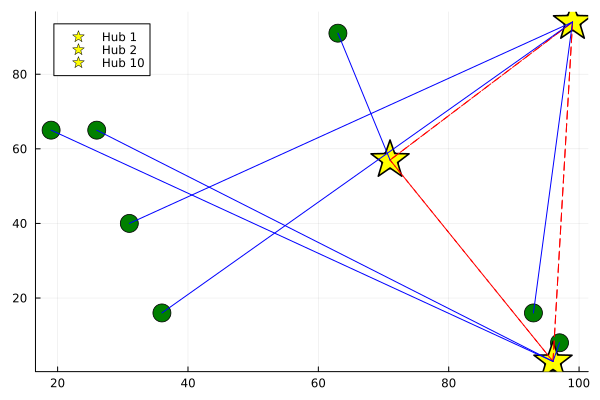

In [50]:
solveCRPC()